In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from connect_to_database import set_connection_string, database_connection, set_engine, get_data_from_db

## About

We are gathering data for 30 legendary rock artists in a cloud database (you can find more information about the E.T.L process here; https://github.com/VangelisChocholis/ETL_Spotify_data). The ultimate objective is to create a Streamlit web application that provides real-time visualizations of popularity and trends based on the collected data. In this notebook we conduct Exploratory Data Analysis (EDA).

## Get and Transform data

In [2]:
# SQL query to get the tracks with the current popularity
sql = '''
  SELECT  *
    FROM tracks_table t JOIN albums_table a ON t.album_id=a.album_id
    JOIN artists_table ar ON a.artist_id = ar.artist_id
    JOIN tracks_features_table tf ON t.track_id = tf.track_id
    JOIN tracks_popularity_table tp ON t.track_id = tp.track_id
    WHERE tp.date = (SELECT MAX(date) FROM tracks_popularity_table);
'''


# get connection string
#connection_string = set_connection_string()

# connect to database
#conn = database_connection(connection_string)
# set SQLAlchemy engine
#engine = set_engine(conn)
# get data from database with the SQL query
#data = get_data_from_db(sql, engine)

Read the data (use `get_data_from_db` and the sql query to get data instead of `pd.read_csv`)

In [3]:
# read static data
artists_table = pd.read_csv('artists_table.csv')
albums_table = pd.read_csv('albums_table.csv')
tracks_table = pd.read_csv('tracks_table.csv')
tracks_faeaures_table = pd.read_csv('tracks_features_table.csv')
# read dynamic data
tracks_popularity_table = pd.read_csv('tracks_popularity_table.csv', parse_dates=['date'])
albums_popularity_table = pd.read_csv('albums_popularity_table.csv', parse_dates=['date'])
artists_popularity_table = pd.read_csv('artists_popularity_table.csv', parse_dates=['date'])
artists_followers_table = pd.read_csv('artists_followers_table.csv', parse_dates=['date'])

In [4]:
# merge to get tracks data
data = pd.merge(tracks_table, albums_table, on='album_id')
data = pd.merge(data, artists_table, on='artist_id')
# get the last date of popularity
data = pd.merge(data, tracks_popularity_table.query('date == @tracks_popularity_table.date.max()'), on='track_id')
data = pd.merge(data, tracks_faeaures_table, on='track_id')


#artists = pd.merge(artists_table, artists_popularity_table, on='artist_id')
#artists = pd.merge(artists, artists_followers_table[['artist_id', 'followers']], on='artist_id')

In [5]:
data.columns

Index(['track_id', 'album_id', 'track_name', 'track_duration_ms',
       'track_spotify_url', 'track_preview_url', 'track_duration_display',
       'original_track_name', 'artist_id', 'album_name', 'album_release_date',
       'album_total_tracks', 'album_image_large', 'album_image_medium',
       'album_image_small', 'original_album_name', 'artist_name', 'date',
       'track_popularity', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'danceability', 'energy', 'track_key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type'],
      dtype='object')

In [6]:
# drop unnecessary columns
data = data.drop(['track_spotify_url', 'track_preview_url', 'album_image_large', 
                  'album_image_medium', 'album_image_small',
                  'uri', 'analysis_url', 'track_href', 'duration_ms'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   track_id                5956 non-null   object        
 1   album_id                5956 non-null   object        
 2   track_name              5956 non-null   object        
 3   track_duration_ms       5956 non-null   int64         
 4   track_duration_display  5956 non-null   object        
 5   original_track_name     5956 non-null   object        
 6   artist_id               5956 non-null   object        
 7   album_name              5956 non-null   object        
 8   album_release_date      5956 non-null   int64         
 9   album_total_tracks      5956 non-null   int64         
 10  original_album_name     5956 non-null   object        
 11  artist_name             5956 non-null   object        
 12  date                    5956 non-null   datetime

In [8]:
# check for missing values
data.isna().sum(axis=0)

track_id                  0
album_id                  0
track_name                0
track_duration_ms         0
track_duration_display    0
original_track_name       0
artist_id                 0
album_name                0
album_release_date        0
album_total_tracks        0
original_album_name       0
artist_name               0
date                      0
track_popularity          0
time_signature            0
danceability              0
energy                    0
track_key                 0
loudness                  0
mode                      0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
type                      0
dtype: int64

Now let's check for duplicated tracks. The `track_id` column is a primary key in our database column. Therefore it cannot have duplicates. 


In [9]:
# checking for track_id duplicates
data.duplicated(subset='track_id').sum()

0

There are tracks that are not considered the same by *Spotify*, which is why they have different track_ids.


In [10]:
data['original_track_name'].duplicated(keep='first').sum()

958

We will keep only the most popular version of each duplicated track. We must do this separately for each artist in order to avoid removing tracks that are different but share the same name. Therefore we group by `artist_name` and `original_track_name`. We keep the duplicated tracks with the highest popularity.

In [11]:
data = (data
        .groupby(['artist_name', 'original_track_name'])
        .apply(lambda x: x.sort_values('track_popularity', ascending=False)
               .head(1)
               )
        .reset_index(drop=True)
        )

In [12]:
# convert duration to seconds
data['track_duration_sec'] = data['track_duration_ms']/1000
data = data.drop('track_duration_ms', axis=1)

In [13]:
data.describe()

album_release_date  album_total_tracks                 date  \
count         5114.000000         5114.000000                 5114   
mean          1987.351388           15.302112  2024-01-10 00:00:00   
min           1962.000000            5.000000  2024-01-10 00:00:00   
25%           1973.000000           11.000000  2024-01-10 00:00:00   
50%           1984.500000           12.000000  2024-01-10 00:00:00   
75%           2000.000000           16.000000  2024-01-10 00:00:00   
max           2023.000000           45.000000  2024-01-10 00:00:00   
std             17.110263            7.664261                  NaN   

       track_popularity  time_signature  danceability       energy  \
count       5114.000000     5114.000000    5114.00000  5114.000000   
mean          36.630035        3.890106       0.49451     0.636428   
min            0.000000        0.000000       0.00000     0.002940   
25%           25.000000        4.000000       0.39600     0.463000   
50%           35.000000        4.000000       0.50000     0.671500   
75%           47.000000        4.000000       0.59775     0.843000   
max           90.000000        5.000000       0.93900     1.000000   
std           16.494000        0.422393       0.14518     0.242198   

         track_key     loudness         mode  speechiness  acousticness  \
count  5114.000000  5114.000000  5114.000000  5114.000000   5114.000000   
mean      5.252444    -9.395928     0.741103     0.059711      0.256353   
min       0.000000   -38.575000     0.000000     0.000000      0.000002   
25%       2.000000   -11.656000     0.000000     0.031700      0.013725   
50%       5.000000    -8.636500     1.000000     0.039100      0.123000   
75%       9.000000    -5.989250     1.000000     0.057100      0.446750   
max      11.000000    -0.251000     1.000000     0.959000      0.994000   
std       3.512184     4.722564     0.438072     0.080023      0.289811   

       instrumentalness     liveness      valence        tempo  \
count       5114.000000  5114.000000  5114.000000  5114.000000   
mean           0.140690     0.208192     0.527503   122.409531   
min            0.000000     0.000000     0.000000     0.000000   
25%            0.000023     0.097600     0.327250   101.210250   
50%            0.002290     0.140000     0.532000   121.039500   
75%            0.111000     0.280000     0.734000   139.468250   
max            0.999000     0.993000     0.981000   216.304000   
std            0.267518     0.169209     0.254107    29.267627   

       track_duration_sec  
count         5114.000000  
mean           235.099580  
min              4.066000  
25%            176.126500  
50%            227.673000  
75%            277.969750  
max           1753.773000  
std            101.256872

Here are some notable observations from the `describe()` table, and also information about each column. Inforamtion about the audio features can be found in the Sotify's API documentation (https://developer.spotify.com/documentation/web-api/reference/get-audio-features):

- `album_total_tracks`: the max number is 45, which is quite large

- `track_popularity`: 
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. We can see that 75% of tracks have a popularity score below 46, with only 25% achieving some level of popularity.

- `time_signature`: The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". We have minumum of 0 which is invalid. More than 75% of tracks has time signature "4/4",  something to be expected for the rock genre.

- `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. The average track lies in the middle, with the median and mean danceability being around 0.5.

- `energy`: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. We can see that 50% of the tracks have energy levels exceeding 0.67, leading to the conclusion that our Rock artists generally produce energetic songs.

- `track_key`: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1 (Range: -1 - 11). This is a categorical feature. We will tranform this column later.

- `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. 

- `mode`: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. We will tranform this column later.

- `speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 75 % of tracks do not contain any spoken words.

- `accousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The average track is not accoustic. However, 25% of tracks have an accousticness value of 0.46, increasing the likelihood that these tracks are accoustic.

- `instrumentalness`: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. We can see that 50 % of tracks have nearly zero instumentalness value.

- `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 50% of tracks have a liveness value of 0.14.

- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). Approximately 50% of tracks exhibit a slight 'positive' valence.

- `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. The average track has a tempo of 120 BPM which is the most common tempo in all of music, and is considered Allegro (brisk and lively.) It's a little fast, but not that much.

- `track_duration_sec`: The average track duration is arround 230 seconds.

We must handle `track_key` and `mode` which are categorical variables.

For `track_key`

In [14]:
# convert mode from 1/0 to major/minor
data['mode'] = np.where(data['mode']==1, 'major', 'minor')
data['mode'].head()

0    major
1    major
2    major
3    major
4    major
Name: mode, dtype: object

For the key we create a dictionary with musical notes and the corresponding number.

In [15]:
musical_notes = {
    -1: None,
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

# map musical notes to key
data['track_key'] = data['track_key'].map(musical_notes)
data['track_key'].head()

0    D
1    A
2    D
3    G
4    A
Name: track_key, dtype: object

## Univariate Analysis

We explore `track_key` distributution.

In [16]:
# check for None
data[data['track_key']==None].shape[0]

0

In [17]:
data['track_key'].value_counts()

track_key
A     836
D     787
G     669
C     620
E     537
B     352
F     336
C#    271
G#    212
F#    205
A#    188
D#    101
Name: count, dtype: int64

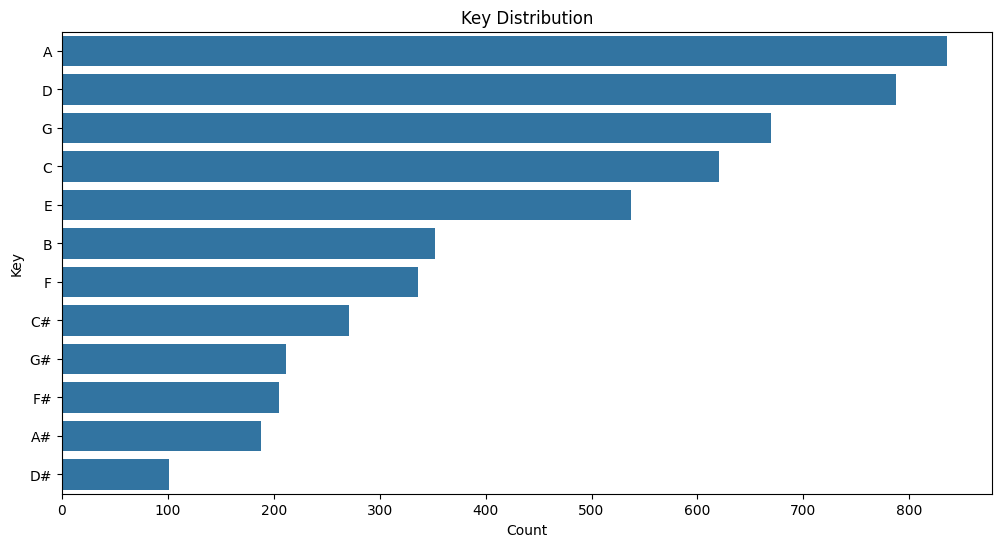

In [18]:
# plot key distribution
plt.figure(figsize=(12,6))
sns.countplot(data['track_key'], order=data['track_key'].value_counts().index)
plt.title('Key Distribution')
plt.xlabel('Count')
plt.ylabel('Key')
plt.show()


Most of the tracks are written in "A" and "D", followed by "G", "C" and "E". Later on, we will investigate the relationship between `track_key` and other features.

Popularity and Key;

We explore `mode` distribution.

In [19]:
data['mode'].value_counts(normalize=True)

mode
major    0.741103
minor    0.258897
Name: proportion, dtype: float64

74% of tracks are written in a "major" scale. Let's check if this changes for tracks with very high popularity.

In [20]:
# find 95th percentile
data['track_popularity'].quantile(0.95)

66.0

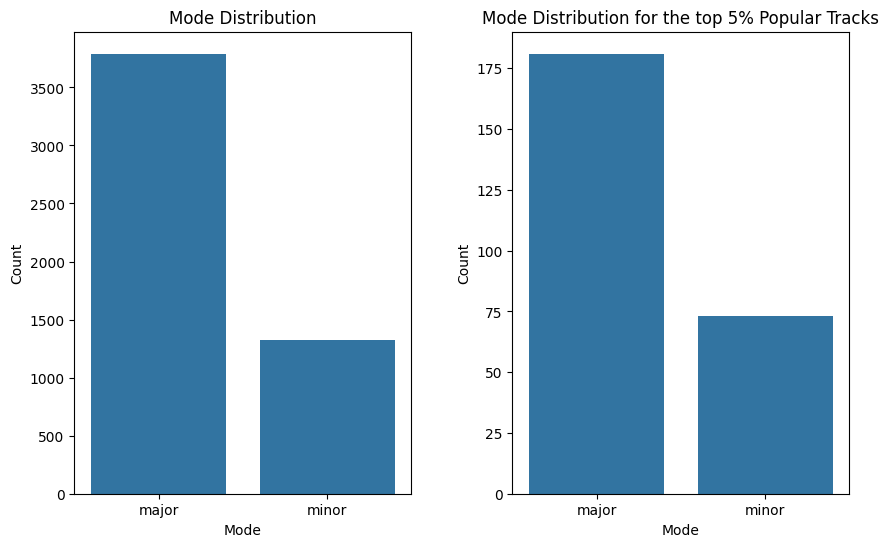

In [21]:
plt.figure(figsize=(10,6))
# plot mode distribution
plt.subplot(1,2,1)
sns.barplot(y=data['mode'].value_counts().values, x=data['mode'].value_counts().index)
plt.title('Mode Distribution')
plt.xlabel('Mode')
plt.ylabel('Count')

# for very popular tracks
plt.subplot(1,2,2)
sns.barplot(y=data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['mode'].value_counts().values, 
            x=data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['mode'].value_counts().index)
plt.title('Mode Distribution for the top 5% Popular Tracks')
plt.xlabel('Mode')  
plt.ylabel('Count')

plt.subplots_adjust(wspace=0.3)
plt.show()


Mode and Popularity

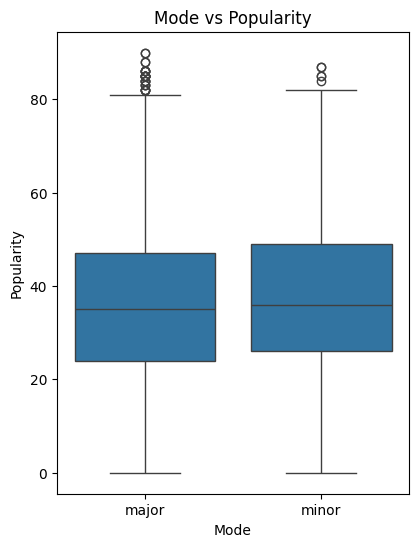

In [22]:
plt.figure(figsize=(10,6))
# plot relation between mode and popularity
plt.subplot(1,2,1)
sns.boxplot(x=data['mode'], y=data['track_popularity'])
plt.title('Mode vs Popularity')
plt.xlabel('Mode')
plt.ylabel('Popularity')
plt.show()



There is no significant difference between major and minor scale when we inlcude all the tracks. However, we must investigate tracks with high popularity. We will make boxplots for the top 5% popular traks.

In [23]:
# find the 95th percentile of popularity
data['track_popularity'].quantile(0.95)

66.0

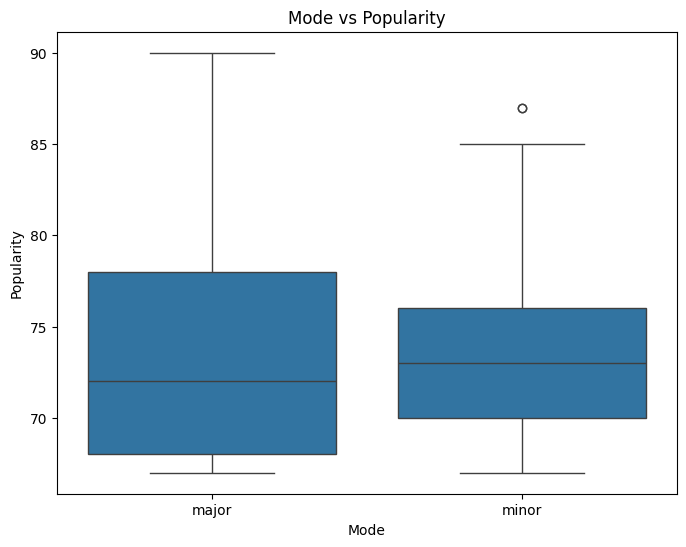

In [24]:
# plot relation between mode and popularity
plt.figure(figsize=(8,6))
sns.boxplot(x=data['mode'], y=data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['track_popularity'])
plt.title('Mode vs Popularity')
plt.xlabel('Mode')
plt.ylabel('Popularity')
plt.show()


There is not statistical difference between the two scales

In [25]:
# make hypothesis test to check if there is a significant difference between the two modes for the top 5% popular tracks
major = data.query('mode == "major" & track_popularity > @data["track_popularity"].quantile(0.95)')['track_popularity']
minor = data.query('mode == "minor" & track_popularity > @data["track_popularity"].quantile(0.95)')['track_popularity']
p_value = stats.ttest_ind(major, minor)[1]
print(f"p value is: {p_value}")
if p_value < 0.05:
    print('There is a significant difference between the two modes')
else:
    print('Failed to reject the null hypothesis that the difference in means is due to chance.')

p value is: 0.5081882278811604
Failed to reject the null hypothesis that the difference in means is due to chance.


Explore `time_signature` distribution.

In [26]:
# convert time signature to string with proper format
data['time_signature'] = data['time_signature'].apply(lambda x: str(x) + "/" + "4")

In [27]:
data['time_signature'].value_counts()

time_signature
4/4    4541
3/4     476
5/4      53
1/4      37
0/4       7
Name: count, dtype: int64

Note that 0/4 and 1/4 are invalid time signatures.

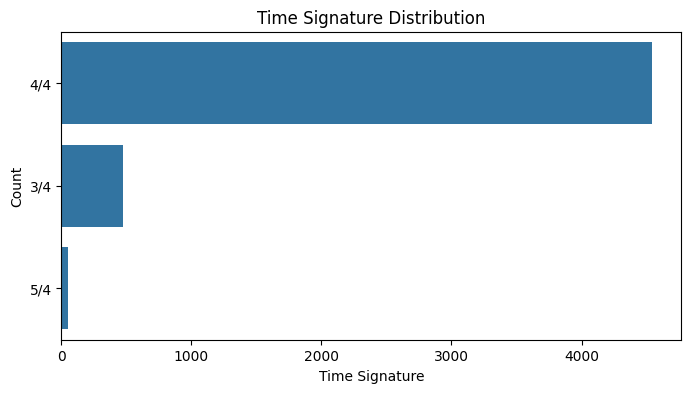

In [28]:
# plot time signature distribution
plt.figure(figsize=(8,4))
sns.countplot(data.query('time_signature != "0/4" &  time_signature != "1/4"')['time_signature'], 
              order=data.query('time_signature != "0/4" &  time_signature != "1/4"')['time_signature'].value_counts().index)
plt.title('Time Signature Distribution')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.show()


The majority of the tracks are written in 4/4, the most common time signature in popular music. There is a small percentage of tracks written in 3/4.

We explore `track_popularity` distribution.

In [29]:
def plot_feature_distribution(data, feature, bins):
    """Plot the distribution of a feature with median line
    Args:
        data (pd.DataFrame): The data to be used
        feature (string): The feature to be plotted
        bins (int): The number of bins to be used in the histogram
    """
    plt.figure(figsize=(10,6))
    sns.histplot(data[feature], bins=bins)
    # display median
    median_value = data[feature].median()
    plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label='Median')
    plt.text(median_value, plt.ylim()[1]*0.9, f'Median: {median_value:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
    plt.title(f'{feature.capitalize()} Distribution')
    plt.show()
    

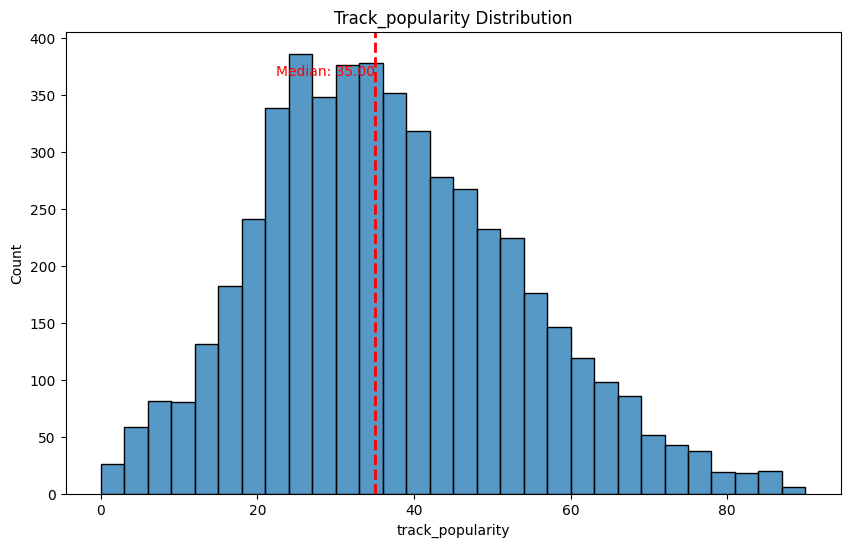

In [30]:
#  plot track_popularity distribution
plot_feature_distribution(data, 'track_popularity', bins=30)




`track_popularity` is approximately normally distributed (with a right skew). 

68.36% of the tracks within 1 sigma
95.87% of the tracks within 2 sigma
99.88% of the tracks within 3 sigma


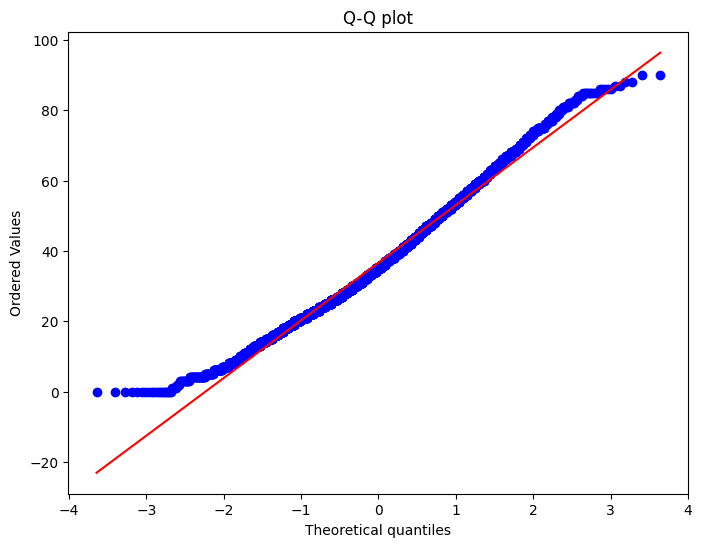

In [31]:
# 68 - 95 - 99.7 rule
def check_normality(data, feature):    
    sigma = data[feature].std()
    mu = data[feature].mean()
    #1 sigma
    pop_1sigma = data.query('(@data[@feature] > @mu - @sigma) & (@data[@feature] < @mu + @sigma)').shape[0]
    print(f"{(pop_1sigma / data.shape[0]) * 100:.2f}% of the tracks within 1 sigma")
    #2 sigma
    pop_2sigma = data.query('(@data[@feature] > @mu - 2*@sigma) & (@data[@feature] < @mu + 2*@sigma)').shape[0]
    print(f"{pop_2sigma / data.shape[0] * 100:.2f}% of the tracks within 2 sigma")
    # 3 sigma
    pop_3sigma = data.query('(@data[@feature] > @mu - 3*@sigma) & (@data[@feature] < @mu + 3*@sigma)').shape[0]
    print(f"{pop_3sigma / data.shape[0] * 100:.2f}% of the tracks within 3 sigma")

check_normality(data, 'track_popularity')

# qq plot
plt.figure(figsize=(8,6))
stats.probplot(data['track_popularity'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()


We explore `danceability` distribution. This variable follows a normal distribution.

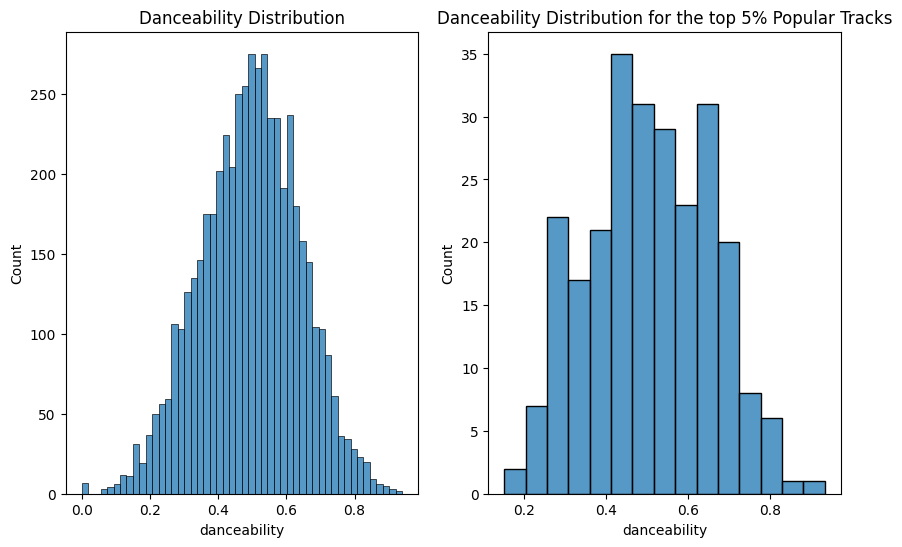

In [32]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.histplot(data['danceability'], bins=50)
plt.title('Danceability Distribution')

plt.subplot(1,2,2)
sns.histplot(data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['danceability'], bins=15)
plt.title('Danceability Distribution for the top 5% Popular Tracks')
plt.show()

67.50% of the tracks within 1 sigma
95.48% of the tracks within 2 sigma
99.82% of the tracks within 3 sigma


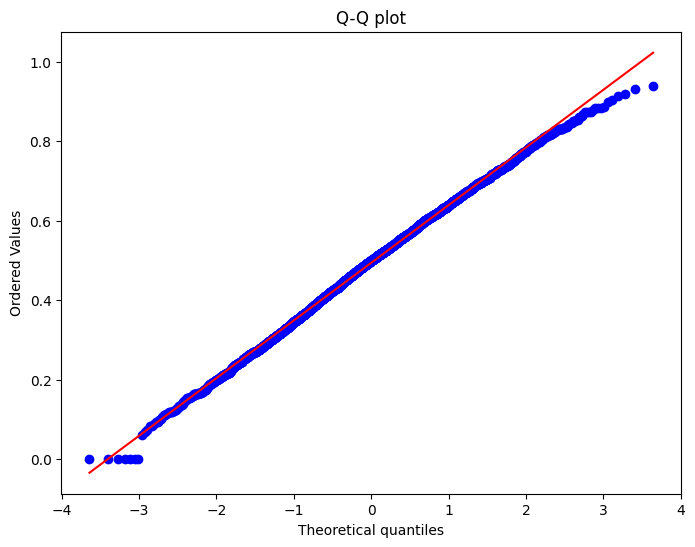

In [33]:
check_normality(data, 'danceability')
# QQ plot
plt.figure(figsize=(8,6))
stats.probplot(data['danceability'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

We explore`energy` distribution. A significant percentage of tracks are very energetic. 

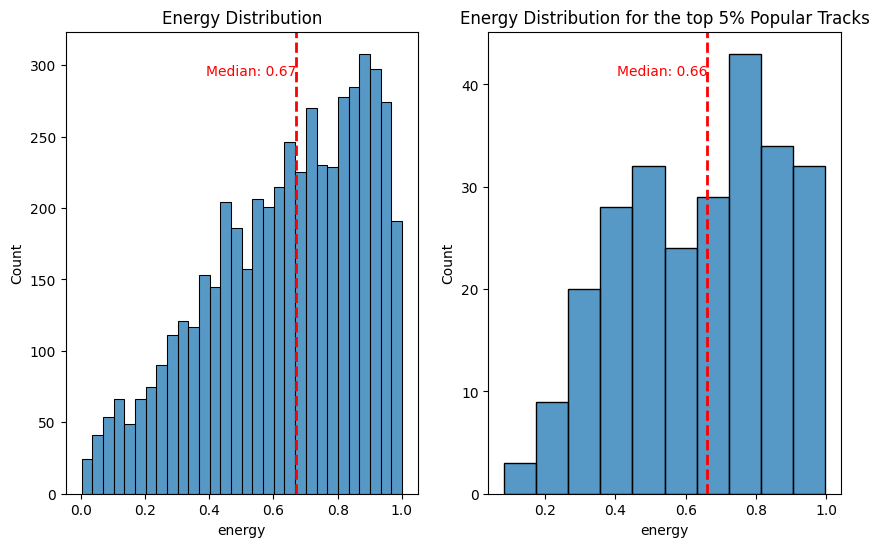

In [34]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.histplot(data['energy'], bins=30)
# display median
median_value = data['energy'].median()
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.text(median_value, plt.ylim()[1]*0.9, f'Median: {median_value:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Energy Distribution')


# for very popular tracks
plt.subplot(1,2,2)
sns.histplot(data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['energy'], bins=10)
# display median
median_value = data.query('track_popularity > @data["track_popularity"].quantile(0.95)')['energy'].median()
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.text(median_value, plt.ylim()[1]*0.9, f'Median: {median_value:.2f}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.title('Energy Distribution for the top 5% Popular Tracks')
plt.show()


We explore the distribution of `loudness`. Initially, it appears to follow a left-skewed distribution. However, upon applying a proper transformation, the variable follows a normal distribution.

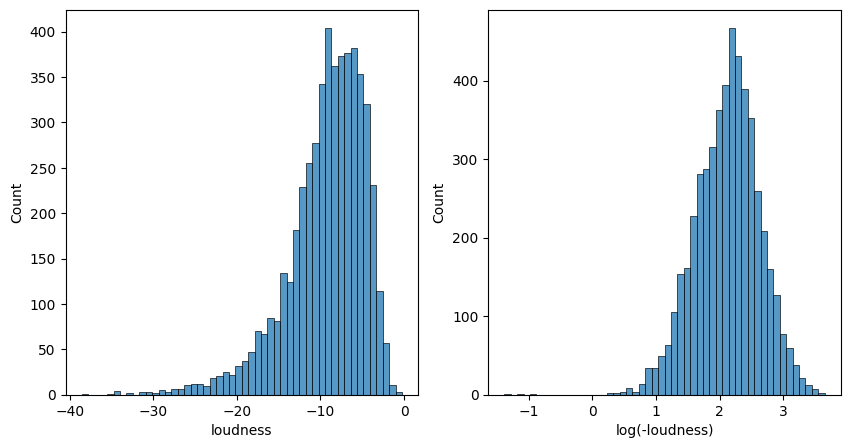

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(data['loudness'], bins=50)

# transform loudness
data['loudness_transformed'] = np.log(-data['loudness'])
# plot tranformed loudness
plt.subplot(1,2,2)
sns.histplot(data['loudness_transformed'], bins=50)
plt.xlabel('log(-loudness)')
plt.show()

69.14% of the tracks within 1 sigma
95.54% of the tracks within 2 sigma
99.67% of the tracks within 3 sigma


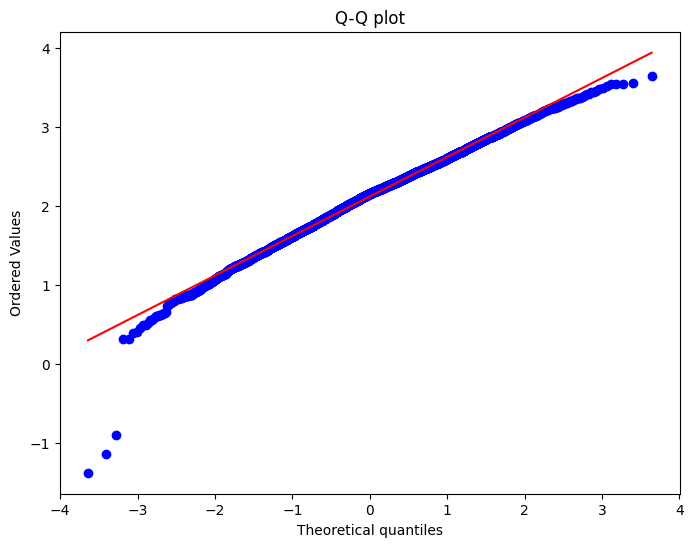

In [36]:
check_normality(data, 'loudness_transformed')
# QQ plot
plt.figure(figsize=(8,6))
stats.probplot(data['loudness_transformed'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

We explore distribution of `speechiness`.

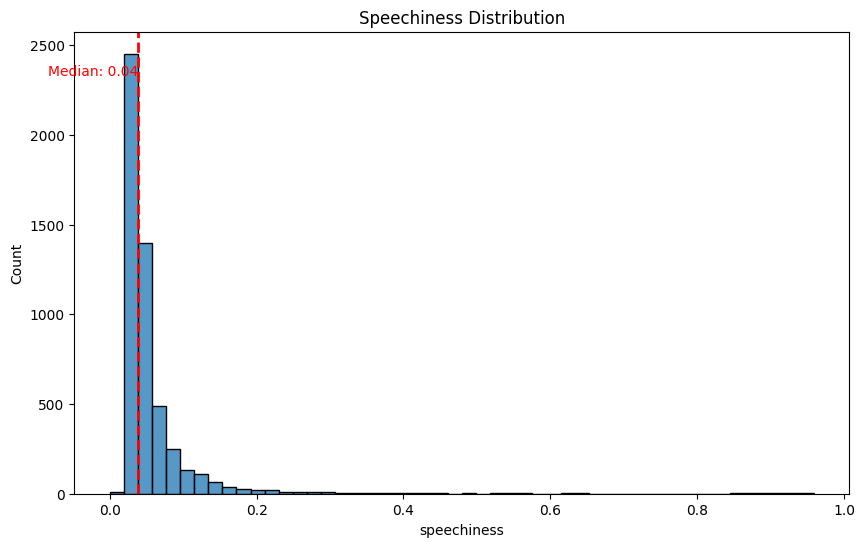

In [37]:
# plot speechiness distribution
plot_feature_distribution(data, 'speechiness', bins=50)

We explore `acousticness` distribution.

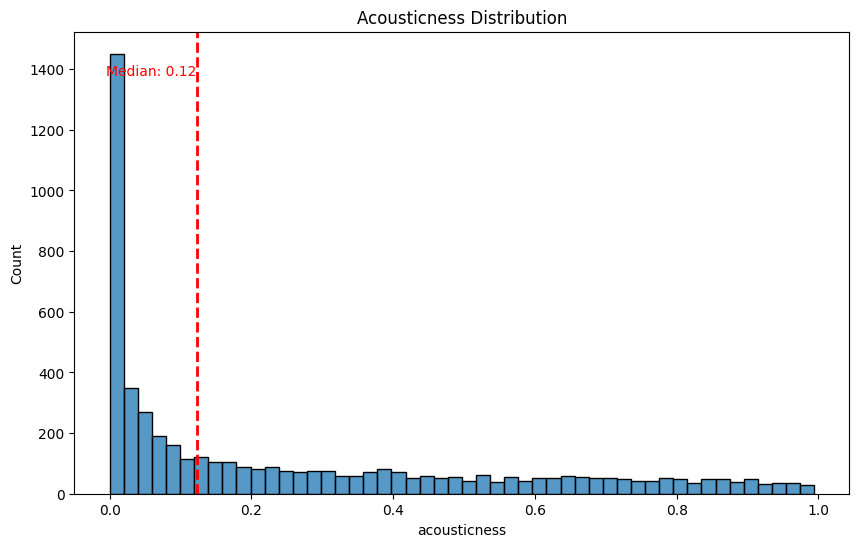

In [38]:
# plot acousticness distribution
plot_feature_distribution( data, 'acousticness', bins=50)

Most of the tracks are not acoustic.

We explore `instrumentalness` distribution.

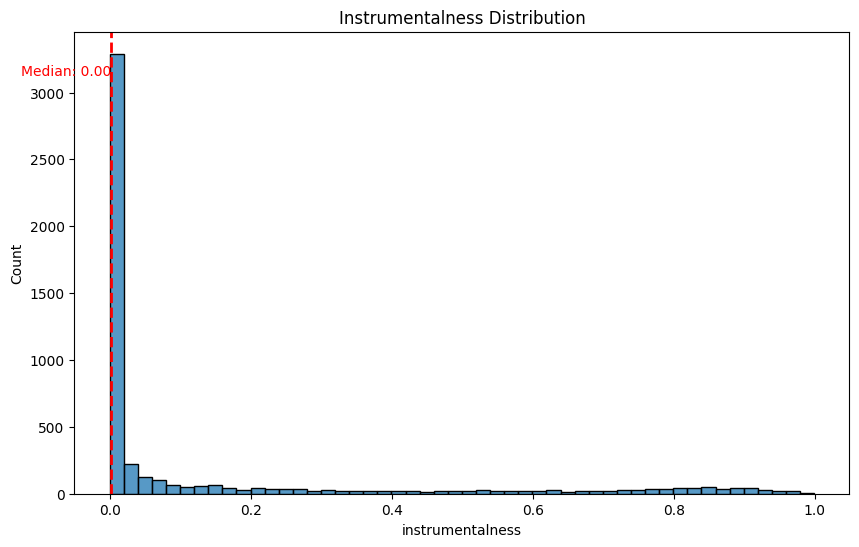

In [39]:
# plot instrumentalness distribution
plot_feature_distribution(data, 'instrumentalness', bins=50)

We explore `liveness` distribution.

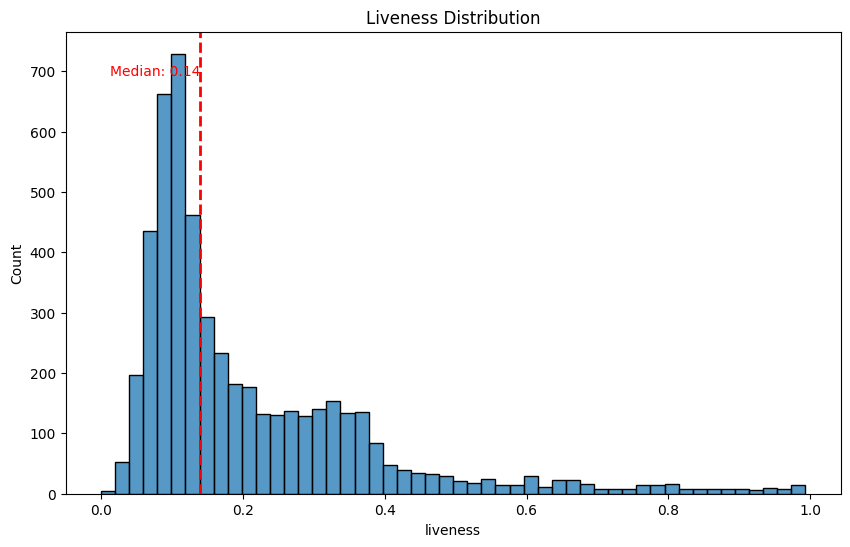

In [40]:
# plot liveness distribution
plot_feature_distribution(data, 'liveness', bins=50)

We explore `valence` distribution.

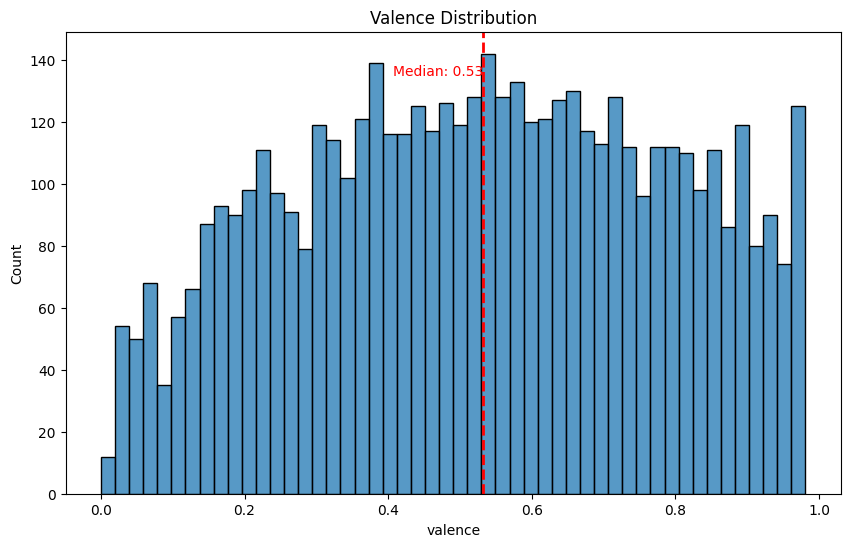

In [41]:
# plot valence distribution
plot_feature_distribution(data, 'valence', bins=50)

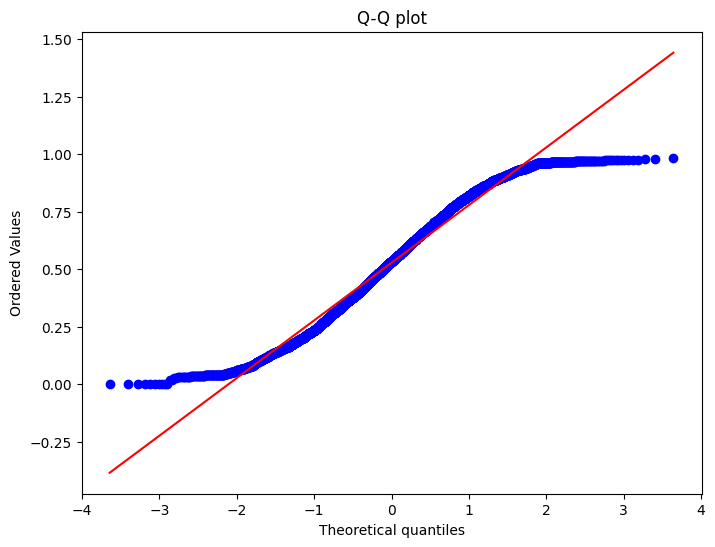

In [42]:
# QQ plot
plt.figure(figsize=(8,6))
stats.probplot(data['valence'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

We explore `tempo` distribution.

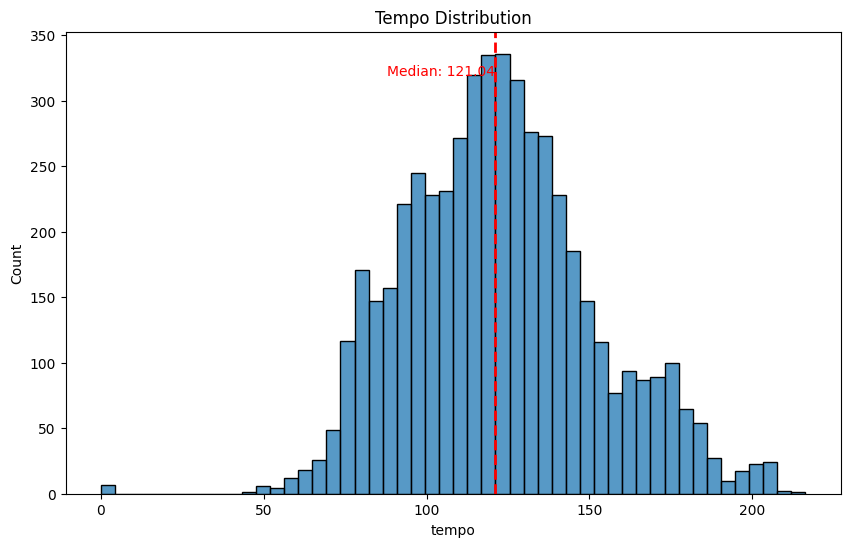

In [43]:
plot_feature_distribution(data, 'tempo', bins=50)

For top 5% popular tracks;

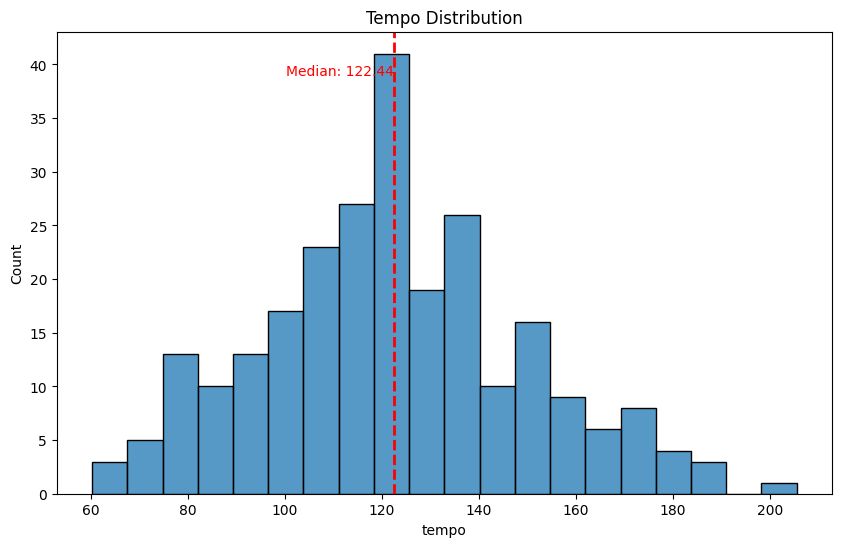

In [44]:
# for top 5% popular tracks
plot_feature_distribution(data.query('track_popularity > @data["track_popularity"].quantile(0.95)'), 'tempo', bins=20)

68.52% of the tracks within 1 sigma
95.97% of the tracks within 2 sigma
99.84% of the tracks within 3 sigma


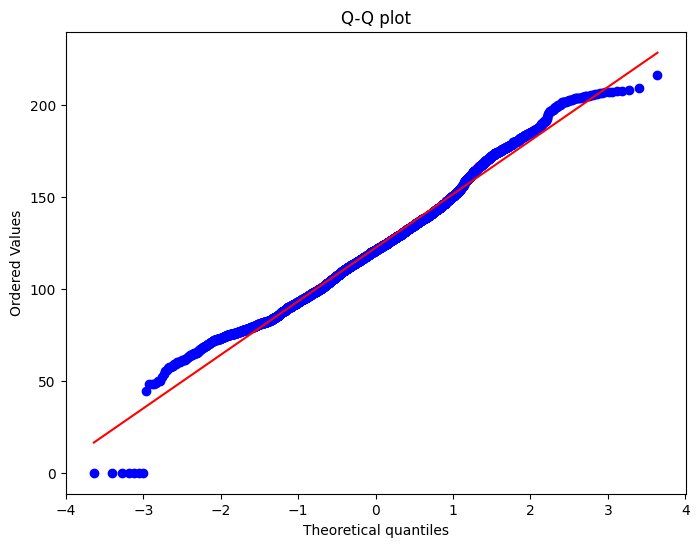

In [45]:
# check normality of tempo
check_normality(data, 'tempo')

# QQ plot
plt.figure(figsize=(8,6))
stats.probplot(data['tempo'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

We explore `track_duration_sec` distribution.

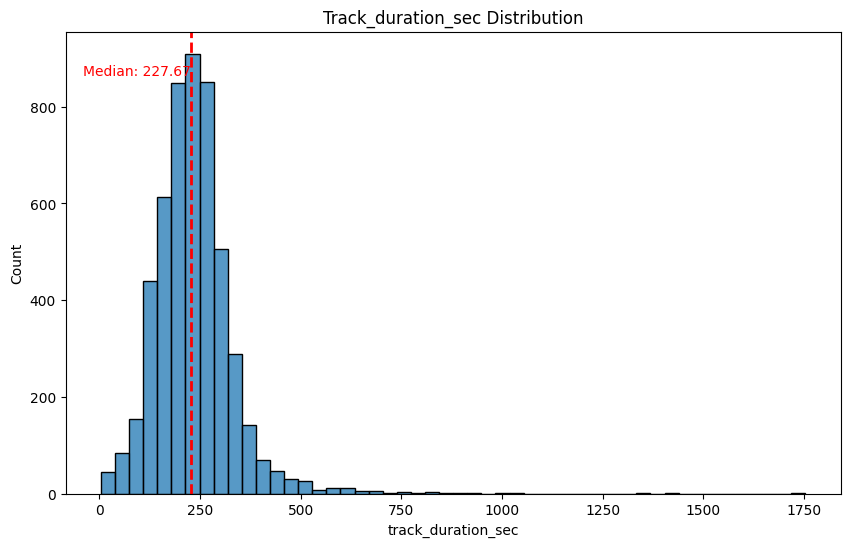

In [46]:
# plot duration distribution
plot_feature_distribution(data, 'track_duration_sec', bins=50)

Nothing changes for the top 5% popular tracks.

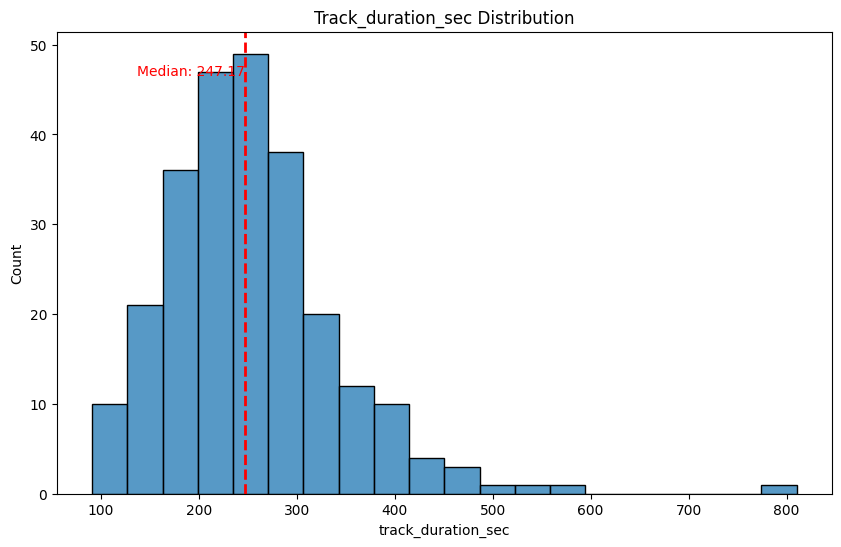

In [47]:
# for top 5% popular tracks
plot_feature_distribution(data.query('track_popularity > @data["track_popularity"].quantile(0.95)'), 'track_duration_sec', bins=20)

79.67 % of tracks fall within 1 standard deviation. Track duration is not normaly distributed but it follows a bell-shpaed distribution.

79.61% of the tracks within 1 sigma
96.68% of the tracks within 2 sigma
98.85% of the tracks within 3 sigma


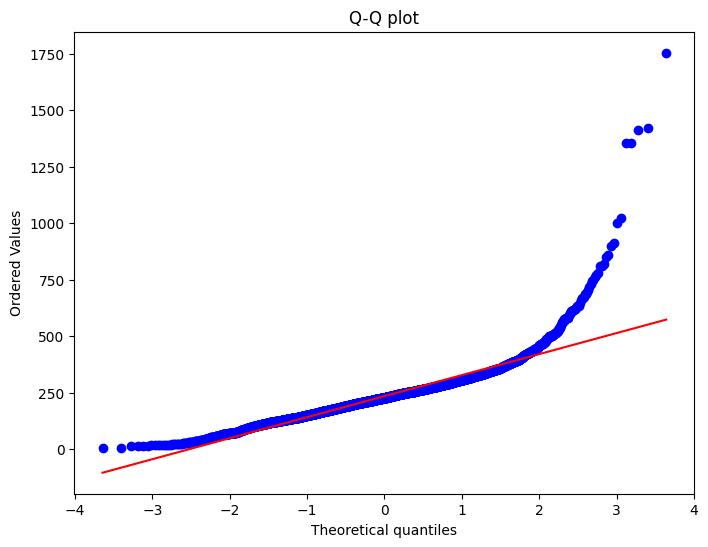

In [48]:
# check normality of duration
check_normality(data, 'track_duration_sec')

# QQ plot
plt.figure(figsize=(8,6))
stats.probplot(data['track_duration_sec'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.show()

## Investigate High Popularity Tracks

- Investigate popularity distribution by artist.

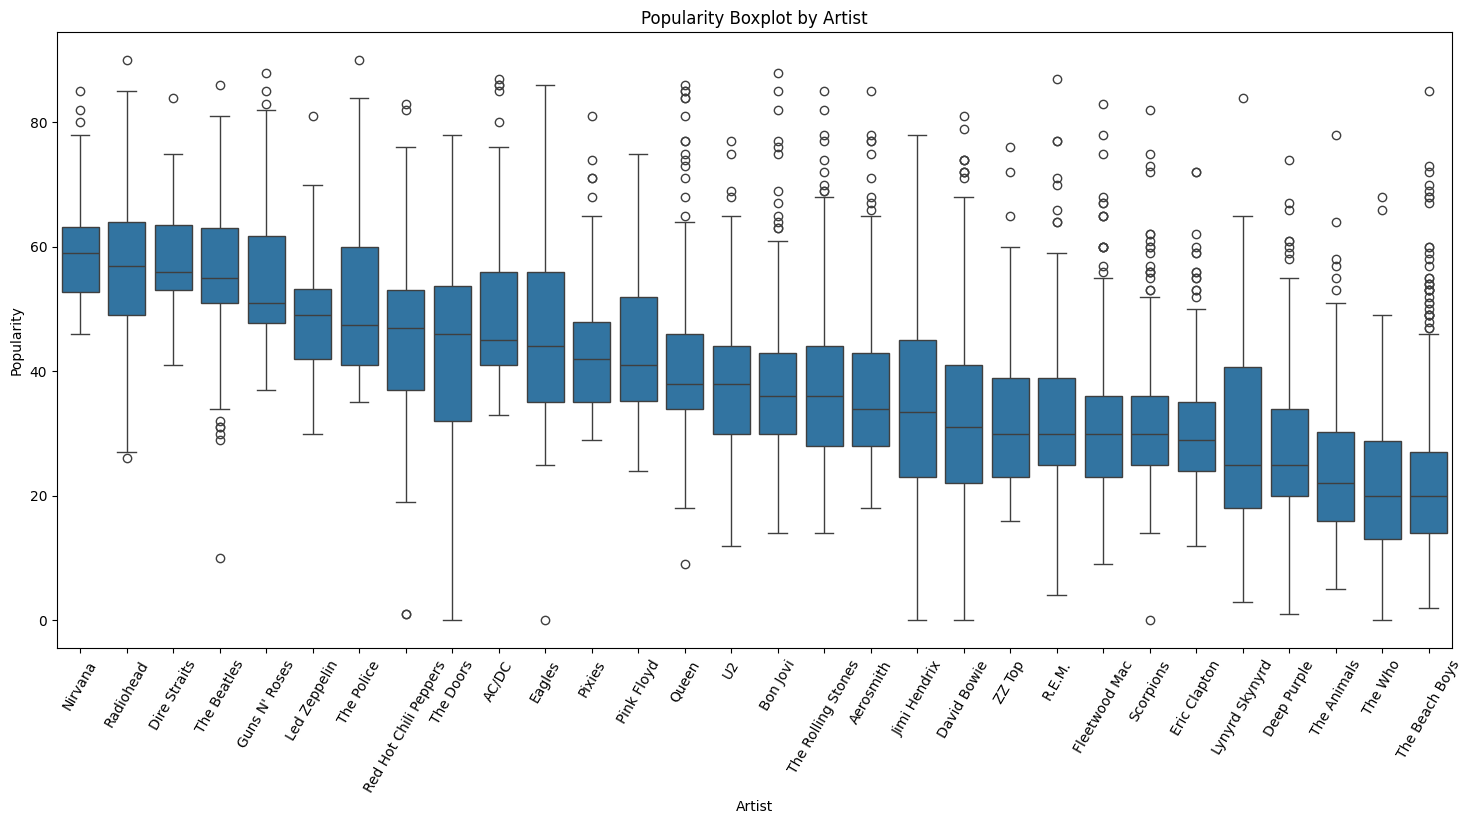

In [49]:
# Sort the data by median popularity
sorted_data = data.groupby('artist_name')['track_popularity'].median().sort_values(ascending=False).index

# Create the boxplot
plt.figure(figsize=(18, 8))
sns.boxplot(data=data, x='artist_name', y='track_popularity', order=sorted_data)
plt.xticks(rotation=60)
plt.title('Popularity Boxplot by Artist')
plt.xlabel('Artist')
plt.ylabel('Popularity')
plt.show()


- Let's investigate the most popular tracks. Which artist have the most tracks in the top 5% ?

In [50]:
data['track_popularity'].quantile(0.95)

66.0

In [51]:
group = (data.query('track_popularity > @data["track_popularity"].quantile(0.95)')
         .groupby('artist_name')
         .agg({'track_id': 'count'})
         .rename(columns={'track_id': 'number_of_tracks'})
         .reset_index()
         .sort_values('number_of_tracks', ascending=False)
)

(INCLUDE IN THE APP.)

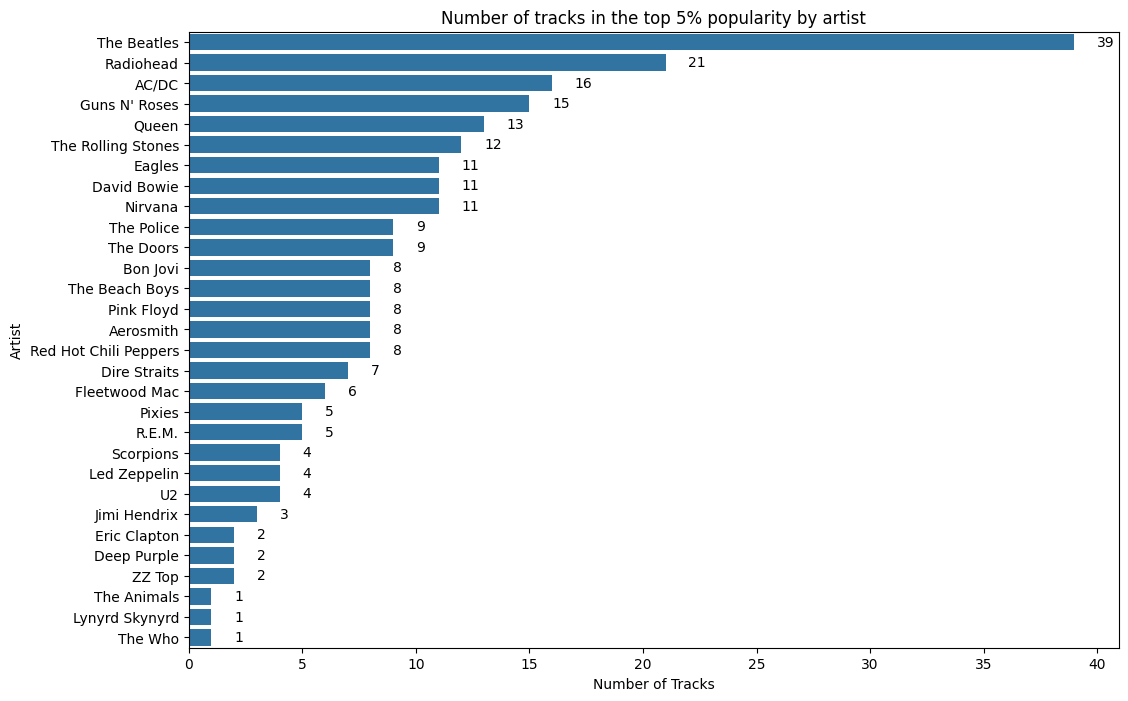

In [52]:
def plot_top_artists(group, n=10, perc=5):
    """Plot the top n artists with the most popular tracks
    Args:
        group (pd.DataFrame): The grouped data containing the number of tracks for each artist 
                            for the top 5% of popular tracks
        n (int): The number of artists to be plotted\
        perc (int): The percentage of popular tracks
    """
    plt.figure(figsize=(12,8))
    sns.barplot(data=group.head(n), y='artist_name', x='number_of_tracks')
    # display the number of tracks next to the bars
    for i in range(n):
        plt.text(group['number_of_tracks'].values[i]+1, i, group['number_of_tracks'].values[i], va='center')
        
    #plt.xticks(np.arange(0, group['number_of_tracks'].max()+1, 1))
    plt.title(f'Number of tracks in the top 5% popularity by artist')
    plt.xlabel('Number of Tracks')
    plt.ylabel('Artist')
    plt.show()

plot_top_artists(group, n=group.shape[0])


The Beatles are extraordinary! Among 30 legendary rock bands, they have 39 tracks in the top 5% of popular tracks.

There are tracks that are considered 'hits,' easily recognizable by everyone even if she/he is not a fan of rock music. Let's assume that these tracks are in the elite of the top 1% of popularity, because it is easier to visualize.

In [53]:
popularity_99th = data['track_popularity'].quantile(0.99)
print(f"1 % of tracks have more than {popularity_99th} popularity")
print(f'''there are {data.query("track_popularity > @popularity_99th").shape[0]} tracks in the top 1% of popularity''')

1 % of tracks have more than 79.0 popularity
there are 50 tracks in the top 1% of popularity


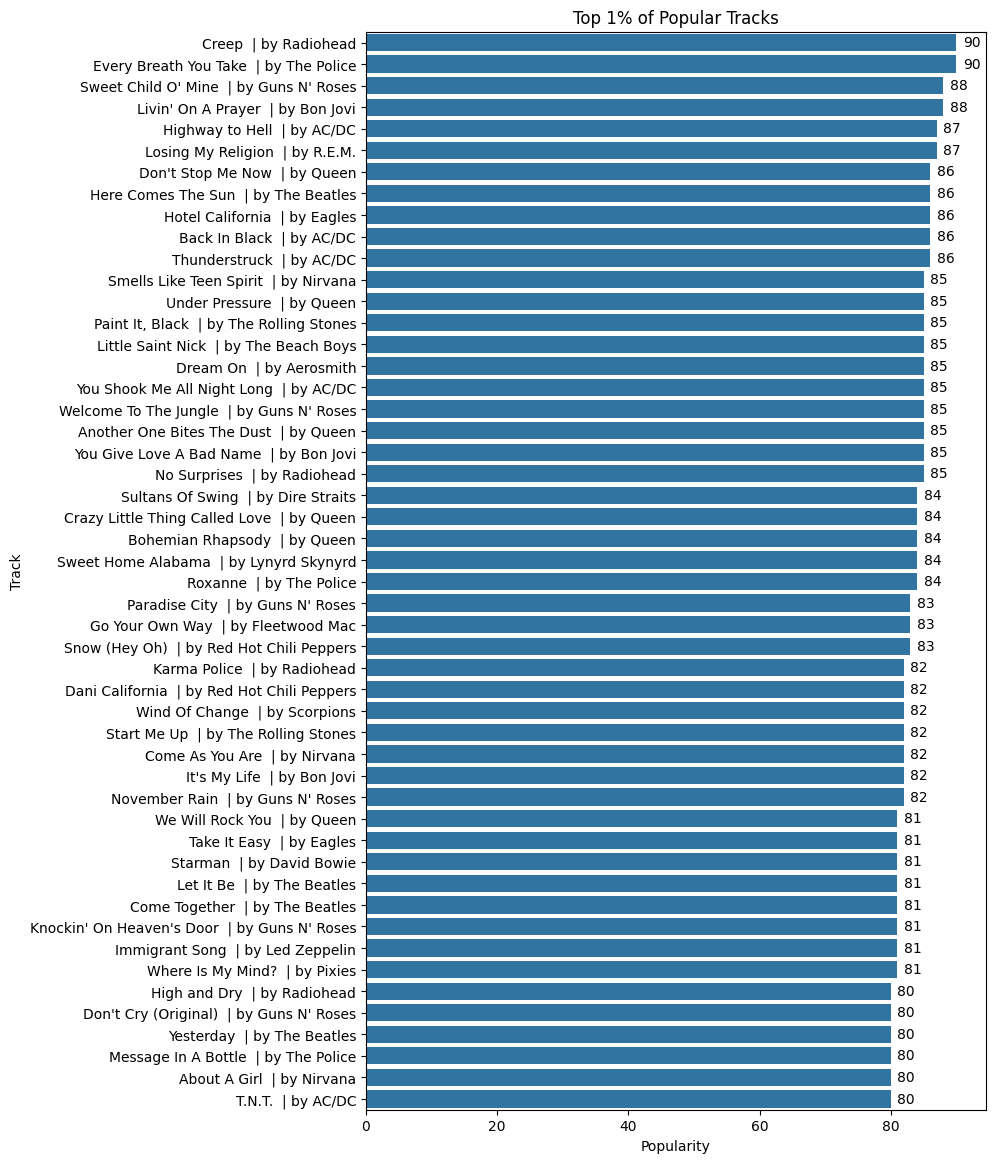

In [54]:
top_tracks = data.query('track_popularity > @popularity_99th').sort_values(by='track_popularity', ascending=False)
top_tracks['track_by_artist'] = top_tracks['original_track_name'] + '  | by ' + top_tracks['artist_name']
plt.figure(figsize=(8,14))
sns.barplot(data=top_tracks,
            y='track_by_artist', x='track_popularity')

# display the popularity next to the bars
for i in range(top_tracks.shape[0]):
    plt.text(top_tracks['track_popularity'].values[i]+1, i, top_tracks['track_popularity'].values[i], va='center')
plt.title('Top 1% of Popular Tracks')
plt.xlabel('Popularity')
plt.ylabel('Track')
plt.show()


Let's see which artist dominates the top 1%.

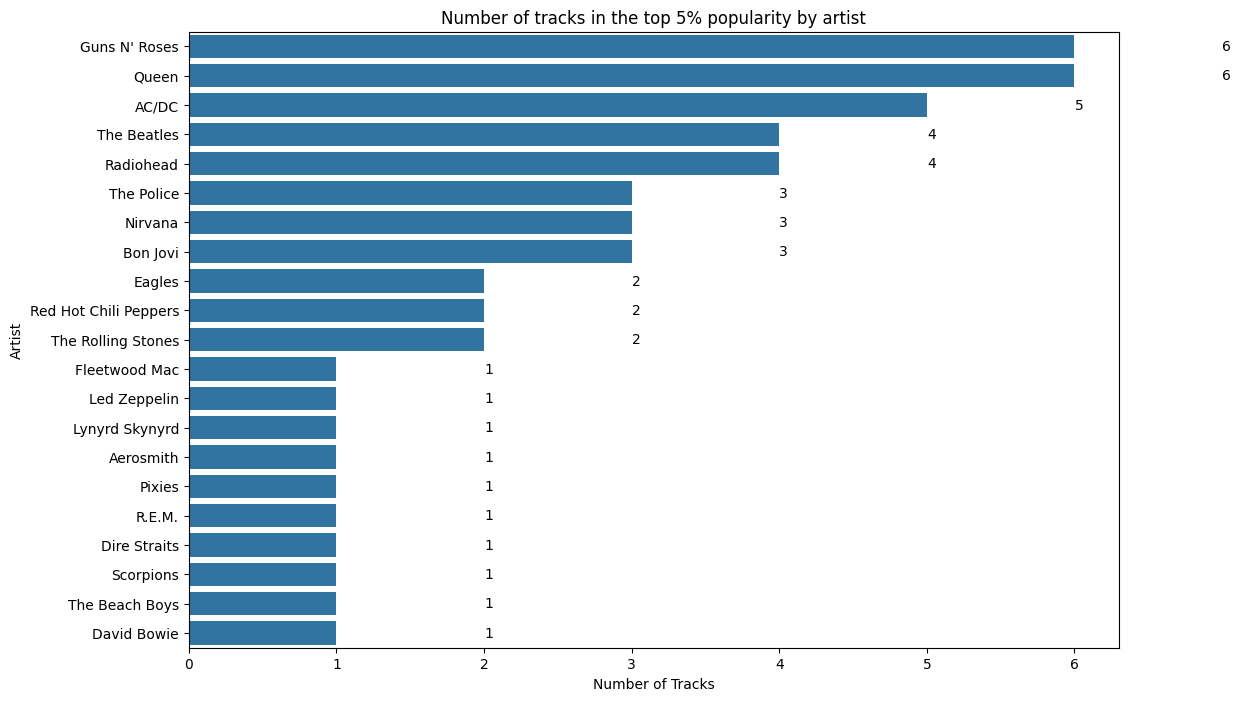

In [55]:
group = (top_tracks
         .groupby('artist_name')
            .agg({'track_id': 'count'})
            .rename(columns={'track_id': 'number_of_tracks'})
            .reset_index()
            .sort_values('number_of_tracks', ascending=False)
            )

# plot top artists with the most tracks in the top 1% of popular tracks
plot_top_artists(group, n=group.shape[0], perc=1)



- For popular tracks (top 5%), we will investigate if their audio features are any different from those of the average-popularity tracks.

In [56]:
popularity_95th = data['track_popularity'].quantile(0.95)
top_tracks = data.query('track_popularity > @popularity_95th').sort_values(by='track_popularity', ascending=False)

In [57]:
from scipy.stats import ttest_ind
# we test features to see if it is significantly different between the top 5% of popular tracks and the rest of the tracks
features = ['danceability', 'energy',  'valence', 'tempo', 'acousticness', 'instrumentalness']
for feature in features:
    top_feature = top_tracks[feature]
    rest_feature = data.query('track_popularity <= @popularity_95th')[feature]
    t_stat, p_value = ttest_ind(top_feature, rest_feature)
    if p_value < 0.05:
        print(f"p-value = {p_value} The mean {feature} of top_tracks is significantly different from the rest of the tracks.")
    else:
        print(f"p-value = {p_value} We cannot reject the null hypothesis that the difference in  {feature} means is due to chance.")
        


p-value = 0.15059562191167133 We cannot reject the null hypothesis that the difference in  danceability means is due to chance.
p-value = 0.9992420769993198 We cannot reject the null hypothesis that the difference in  energy means is due to chance.
p-value = 0.5969111885590198 We cannot reject the null hypothesis that the difference in  valence means is due to chance.
p-value = 0.9534361891928329 We cannot reject the null hypothesis that the difference in  tempo means is due to chance.
p-value = 0.1142286572780254 We cannot reject the null hypothesis that the difference in  acousticness means is due to chance.
p-value = 1.2160637483773791e-06 The mean instrumentalness of top_tracks is significantly different from the rest of the tracks.


There is no significant difference in means for any of the features except for `acousticness`.


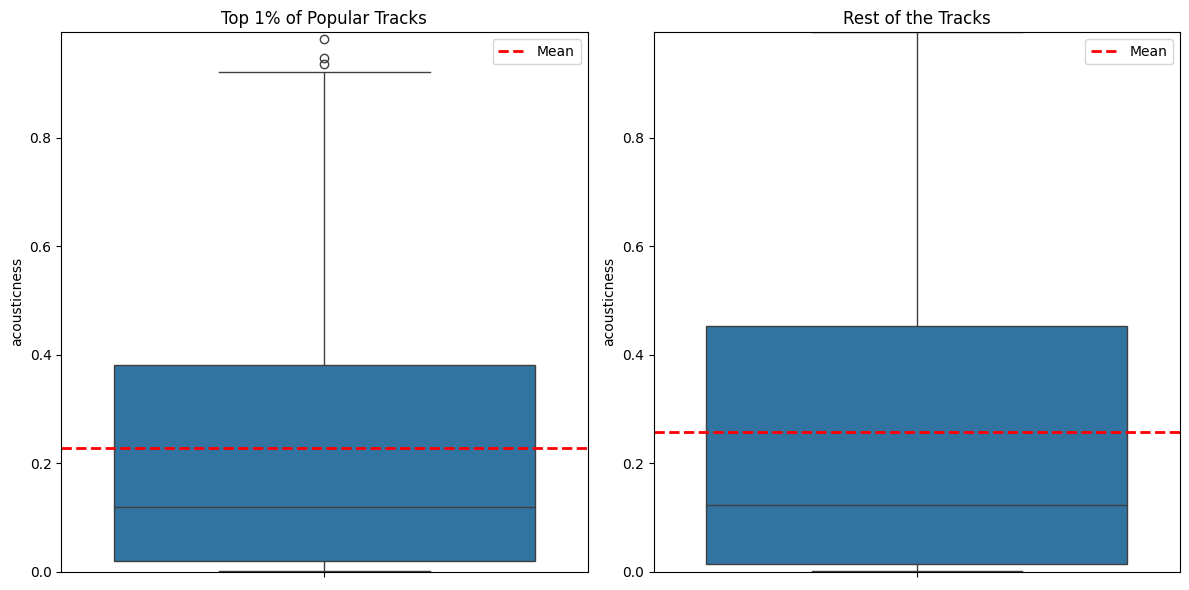

In [58]:
features = ['acousticness']
for feature in features:
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.boxplot(data=top_tracks, y=feature)
    plt.title('Top 1% of Popular Tracks')
    plt.ylabel(feature)
    # set the y-axis limit to be the same for both plots
    plt.ylim(0, data[feature].max())
    plt.axhline(top_tracks[feature].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.legend()
    
    plt.subplot(1,2,2)
    sns.boxplot(data=data.query('track_popularity <= @popularity_95th'), y=feature)
    plt.title('Rest of the Tracks')
    plt.ylabel(feature)
    # set the y-axis limit to be the same for both plots
    plt.ylim(0, data[feature].max())
    plt.axhline(data.query('track_popularity <= @popularity_95th')[feature].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

## Multivariate Analysis

#### Exploring relationships between numerical values.

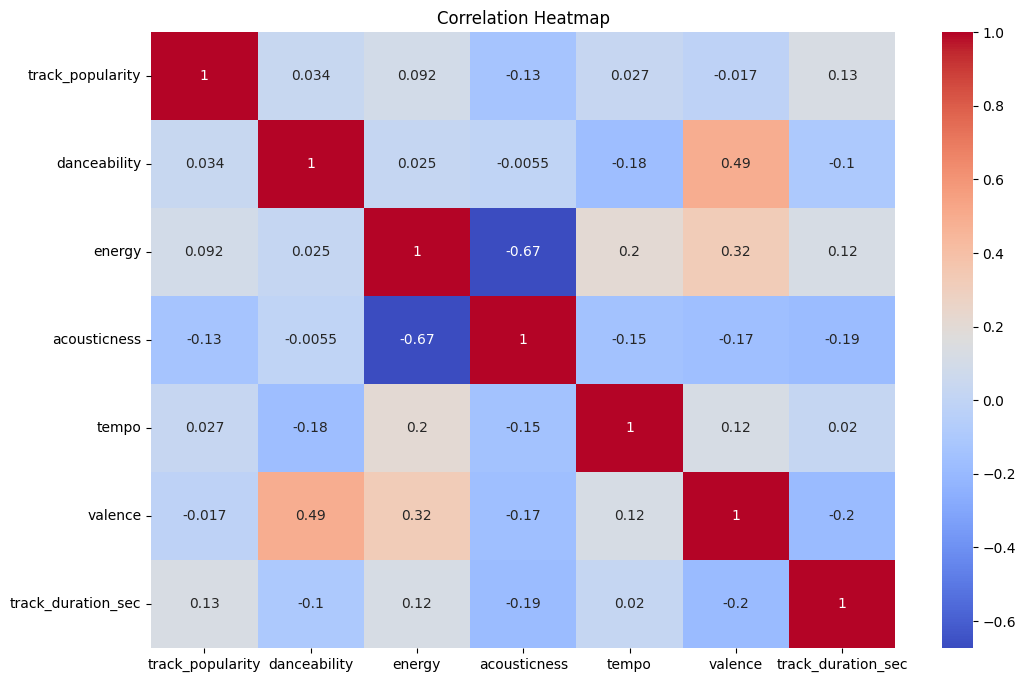

In [79]:
'''sns.heatmap(data=data[['track_popularity', 'danceability',
                        'energy', 'acousticness', 'tempo', 'valence', 'mode', 'track_duration_sec']])'''
# heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data[['track_popularity', 'danceability', 'energy', 'acousticness', 'tempo', 'valence', 'track_duration_sec']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

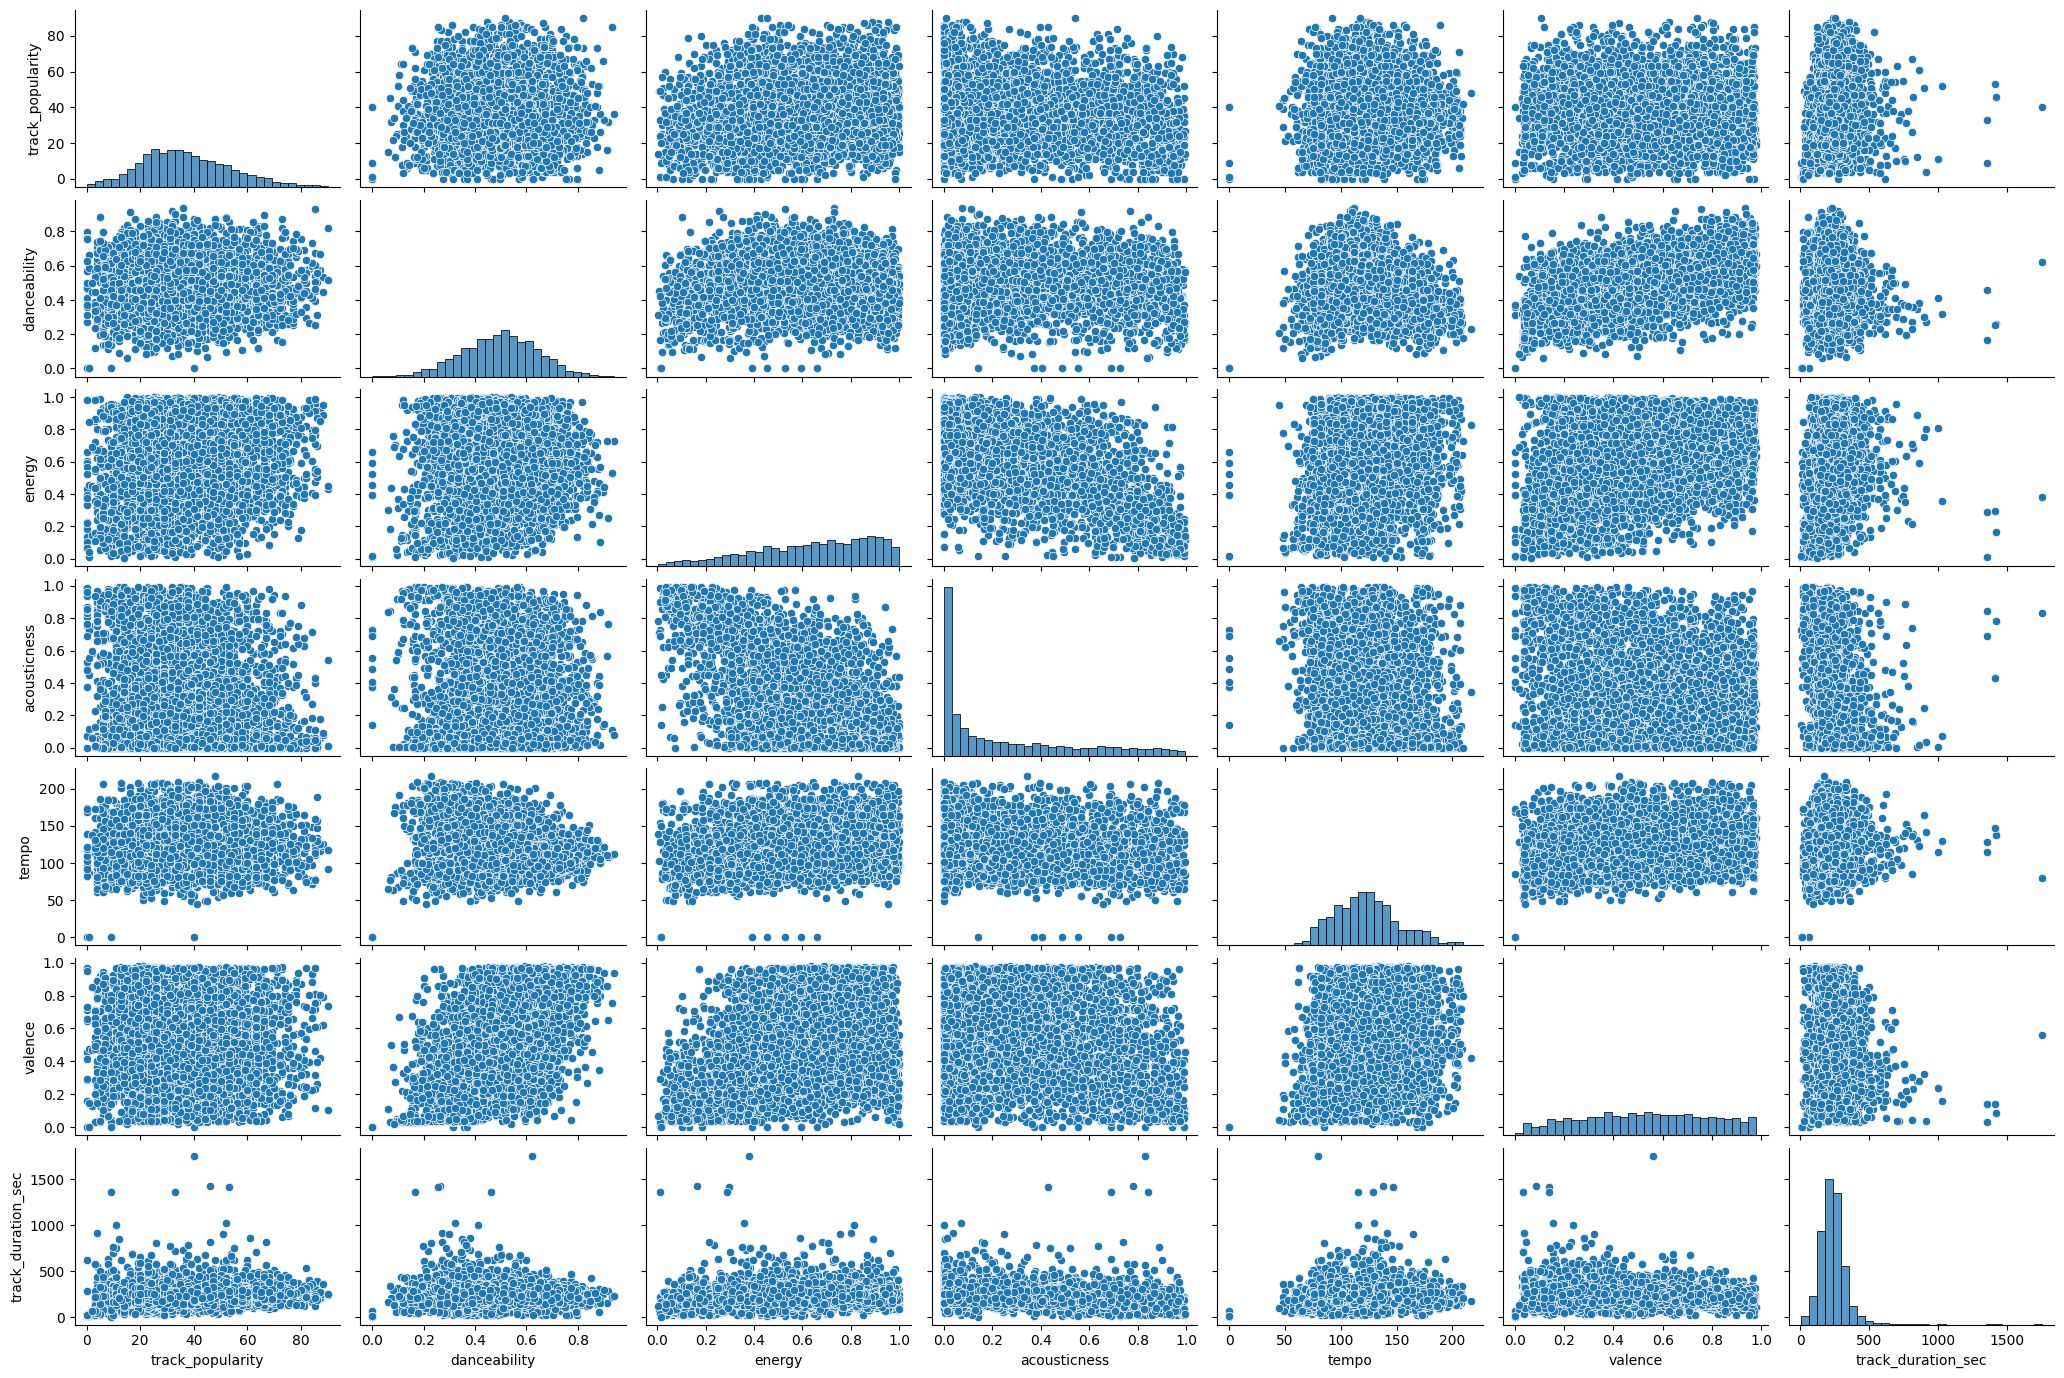

In [80]:
# plot pairplot with increased bars in the diagonal
sns.pairplot(data=data[['track_popularity', 'danceability',
                        'energy', 'acousticness', 'tempo', 'valence', 'mode', 'track_duration_sec']],
             diag_kind="hist", height=2, aspect=1.5, diag_kws={'bins': 30})
plt.show()

For top 5% tracks

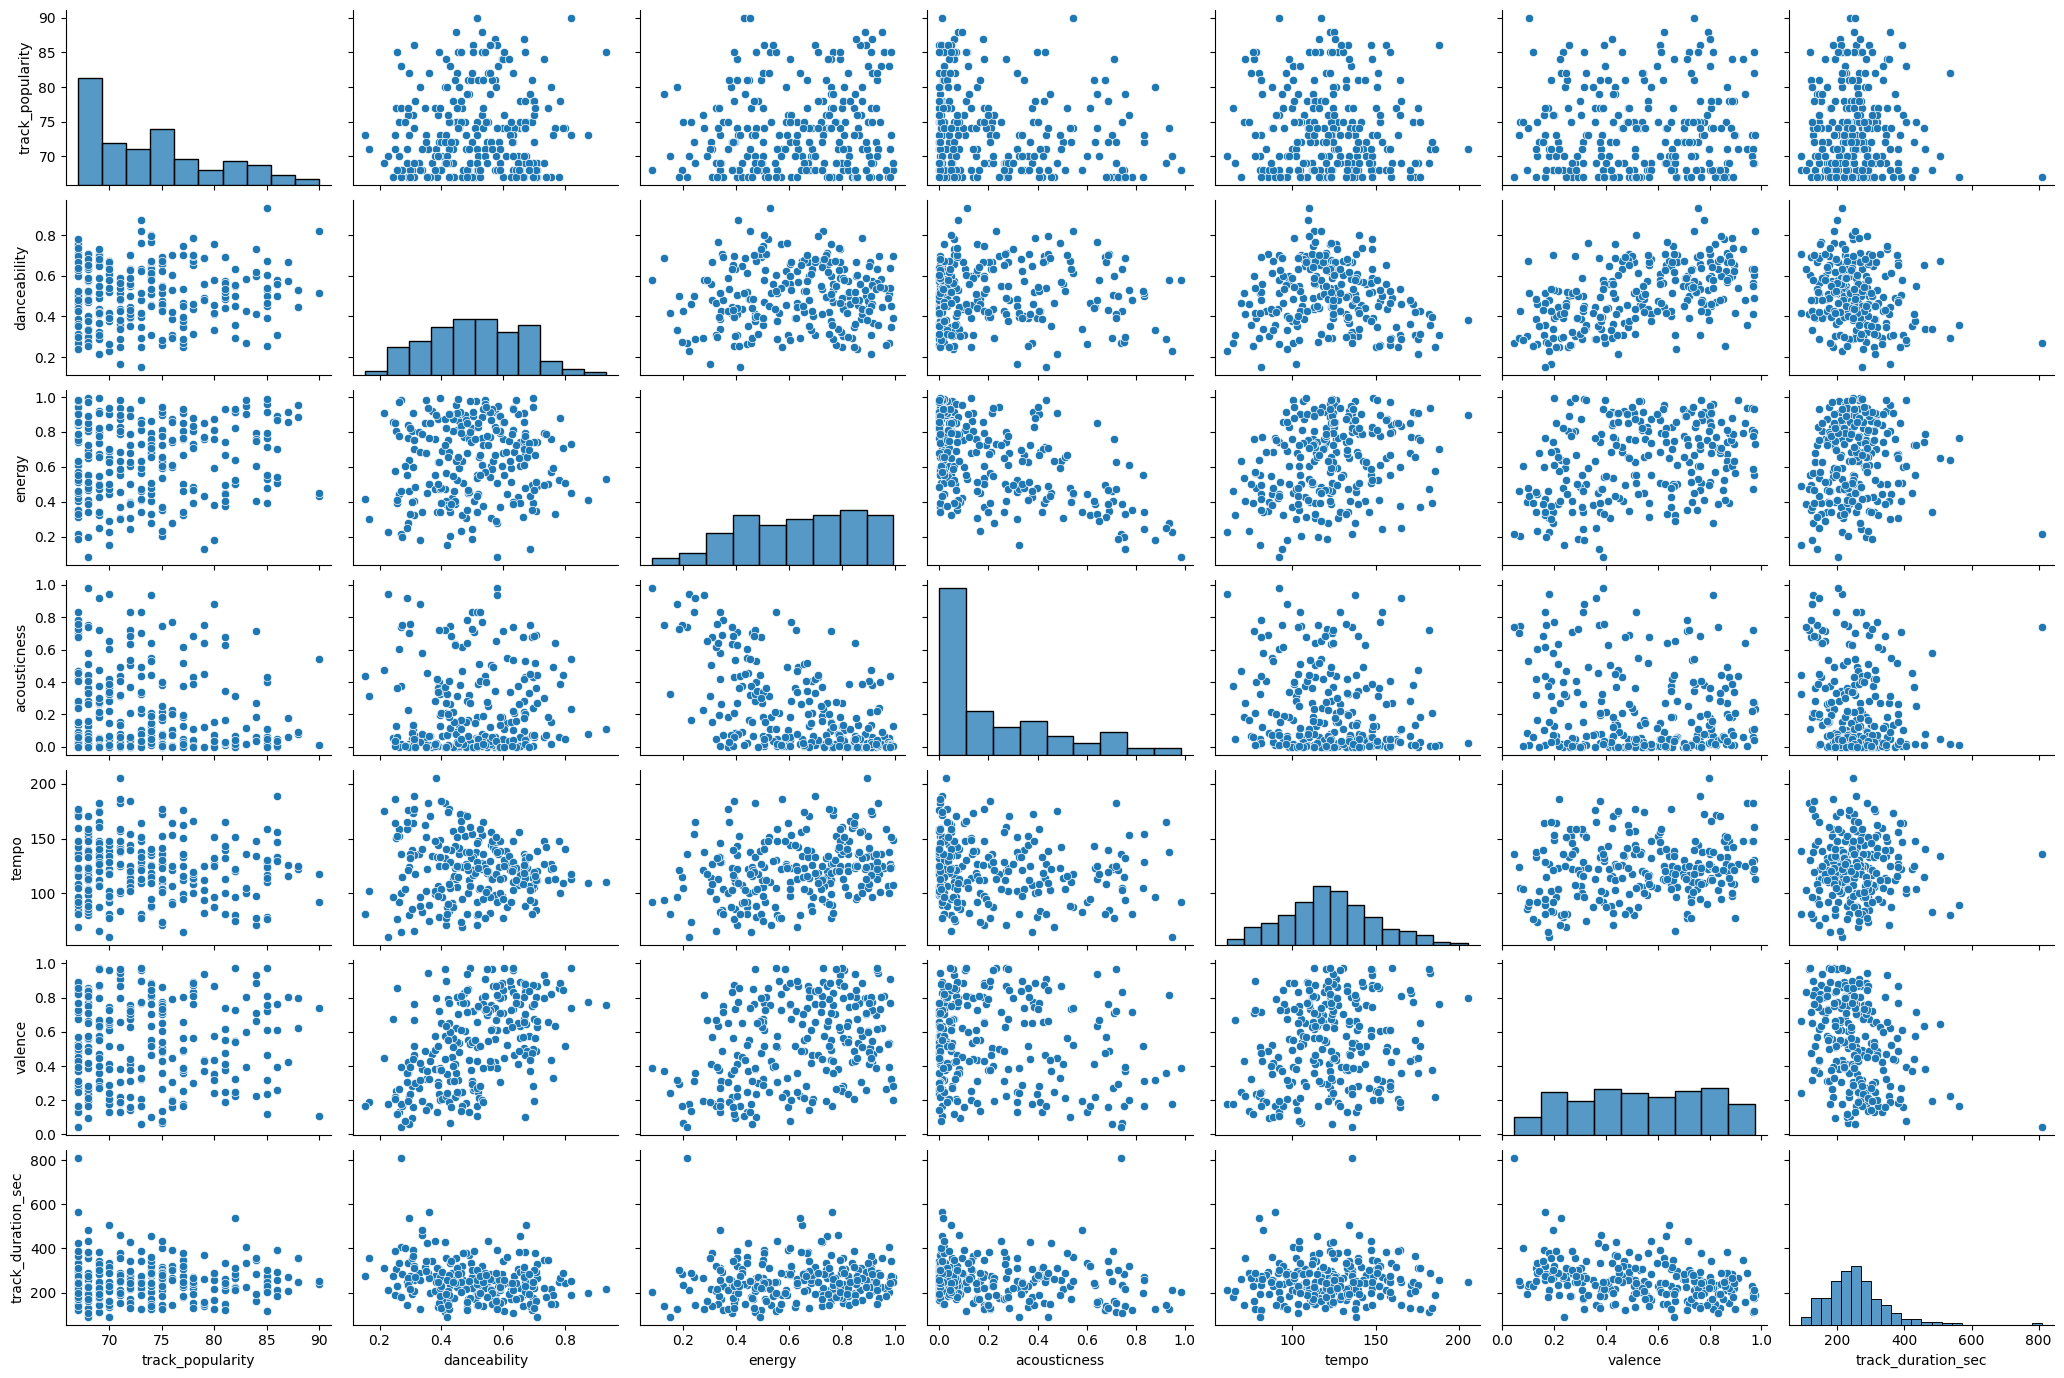

In [81]:
# plot pairplot for top 5% popular tracks
sns.pairplot(data=data.query('track_popularity > @data["track_popularity"].quantile(0.95)')[['track_popularity', 'danceability',
                        'energy', 'acousticness', 'tempo', 'valence', 'mode', 'track_duration_sec']],
             diag_kind="hist", height=2, aspect=1.5)
plt.show()
